In [1]:
#%matplotlib notebook
from pykat import finesse
from pykat.commands import *
import pykat.external.peakdetect as peak
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot as aligoplt
#import pykat
import gwinc as gwinc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

pykat.init_pykat_plotting(dpi=96)

#for animations:
from matplotlib import animation, rc
from IPython.display import HTML
plt.style.use('dark_background')
# Update the matplotlib configuration parameters:
plt.rcParams.update({'text.usetex': False,
                     'lines.linewidth': 2,
                     #'font.family': 'serif',
                     #'font.serif': 'noto',
                     'font.size': 11,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small',
                     'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'axes.grid.axis': 'both',
                     'axes.grid.which': 'both',
                     'axes.grid': True,
                     'grid.color': 'xkcd:gray',
                     'grid.alpha': 0.3,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 'small',
                     'legend.framealpha': 0.8,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.33,
                     'legend.loc': 'best',
                     'figure.figsize': ((7, 4)),
                     'savefig.dpi': 300,
                     'savefig.bbox': 'tight',
                     'pdf.compression': 9})


def radar_plot(self, detector_I, detector_Q, DOFs=None, ax=None, title=None, leg=True, autoscale=True):
    """Generates an I-Q quadrature radar plot from this sensing matrix.
    
    Each radar plot shows the magnitude and phase of the response in that
    sensor for each of the DOFs. e.g. Watts in POP_f1 per meter of ETMX motion
                    
    Parameters
    ----------
    detector_I : str
        Detector name in the sensing matrix for I quadrature
        
    detector_Q : str
        Detector name in the sensing matrix for Q quadrature
        
    DOFs : collection[str], optional
        DOFs in the sensing matrix to plot
    
    ax : axis, optional
        Matplotlib axis to put plot into
        
    title: str, optional
        Title of plot
    """
    
    I = self[detector_I]
    Q = self[detector_Q]
    
    A = I + 1j*Q
    
    # FFS, we need to standardize on the colors for the DOFs with an iron fist
    # DARM = DODGER BLUE, CARM = CARNATION, PRCL=PURPLE, MICH = MIDNIGHT, SRCL = Cyan
    clrs = ['xkcd:Dodger Blue', 'xkcd:Red', 'xkcd:Lavender', 'xkcd:Cyan', 'xkcd:Grey']
    
    _ax = ax or plt.subplot(111, projection='polar')
    _ax.set_theta_zero_location('E')
    r_lim = (np.log10(np.abs(A)).min()-1, np.log10(np.abs(A)).max())
    
    if DOFs and any((_ not in A.keys() for _ in DOFs)):
        raise Exception("Sensing matrix is missing one of DOFs ({0}) requested".format(DOFs))
        
    if DOFs:
        keys = tuple(_ for _ in A.keys() if _ in DOFs)
    else:
        keys = A.keys()
        
    scaling = np.linspace(7, 4, len(keys))
    
    for _, s, cc in zip(keys, scaling, clrs):
        theta = np.angle(A[_])
        r     = np.log10(np.abs(A[_]))
        _ax.plot((theta,theta), (r_lim[0], r), lw=s, label=_, alpha=0.6, color=cc)
    ttl = _ax.set_title(title, fontsize=11)
    ttl.set_position([.5, 1.12])
    
    if autoscale == True:
        _ax.set_ylim(r_lim[0], r_lim[1])
    else:
        _ax.set_ylim(6, 11)
    
    if leg==True:
        _ax.legend(bbox_to_anchor=(0.5, -0.1), ncol=5)
    
    _ax.set_rticks(np.arange(*np.round(r_lim)))
    _ax.set_yticklabels(tuple( "$10^{%s}$" % _ for _ in np.arange(*np.round(r_lim), dtype=int)))
    _ax.grid(True, zorder = -10, lw = 2)
    if ax is None:
        plt.tight_layout()
        plt.show()
        
def prettySensingMatrix(self, cmap = 'jet'):
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    # Set colormap equal to seaborns light green color palette
    cmap = plt.get_cmap(cmap)

    # Set CSS properties for th elements in dataframe
    th_props = [
      ('font-size', '24'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'xkcd:White'),
      ('background-color', 'xkcd:Black')
      ]

    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '24')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]
        
    self = (self.style
      .background_gradient(cmap=cmap, subset=list(self))
      .set_caption('Interferometer Sensing Matrix')
      .format("{:0.3g}")
      .set_table_styles(styles))
    
    return self

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
basekat=finesse.kat() # initialising Finesse
basecode = """
#EOM Modulator frequencies 
const mod_freq45 45M
const mod_freq9  9M

#Mirror Parameters
const PRM_R 0.97            #PRM Reflectivity (R)
const PRM_T 0.03            #PRM Transmission (T)
const PRM_L 8.5e-6          #PRM Loss (L)

const ITMx_R 0.98           #ITMx Reflectivity (R)
const ITMx_T 0.01           #ITMx Transmission (T)
const ITMx_L 3.75e-5        #ITMx Loss (L)

const ITMy_R 0.98           #ITMy Reflectivity (R)
const ITMy_T 0.01           #ITMy Transmission (T)
const ITMy_L 3.75e-5        #ITMy Loss (L)

#Lengths
const L_p   50.0            #Space between PRM and BS
#Schnupp Asymmetry = 0.1m 
#=> lx = 10.0 + 0.1m ; ly = 10.0 - 0.1m
const lx    10.1            #Space between BS and ITMx 
const ly    9.9            #Space between BS and ITMy

#Laser
l LASER 1 0 nLASER          # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 nLASER nEOM45_1      # Space (Length = 1 m)

#EOMs 
mod EOM45 $mod_freq45 0.25 1 pm nEOM45_1 nEOM45_2 #EOM 45MHz       
s sEOM45 1 nEOM45_2 nEOM9_1                       #Space between EOMs
mod EOM9 $mod_freq9 0.25 1 pm nEOM9_1 nEOM9_2     #EOM 9MHz
s sEOM9  1 nEOM9_2  nPRM_1                        #Space between EOM and PRM

#Power Recycling Michealson Interferometer
m1 PRM $PRM_T $PRM_L 0 nPRM_1 nPRM_2            #Power Recycling Mirror
s sPRM_BS 50 nPRM_2 nBS_1                       #Space between PRM and BS
bs BS 0.5 0.5 0 45 nBS_1 nBS_2 nBS_3 nBS_4      #Beam Splitter (BS)      
s sBS_ITMy 10 nBS_2 nITMy_1                     #Space between BS ann ITMy
m1 ITMy $ITMy_T $ITMy_L 0 nITMy_1 dump          #Mirror ITMy
s sBS_ITMx 10 nBS_3 nITMx_1                     #Space between BS and ITMx 
m1 ITMx $ITMx_T $ITMx_L 0 nITMx_1 dump          #Mirror ITMx
"""
basekat.parse(basecode,
              keepComments = True,
              preserveConstants = True)


Pykat parsing does not preserve inline comments. Moving inline
comments before command



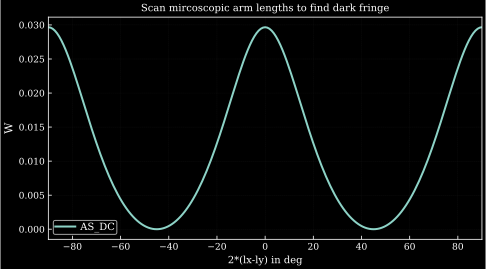

In [3]:
#Find the microscopic mirror positions for dark fringe at the AS_DC port.
#Scan microscopic differential ITMx and ITMy, observe the AS_DC port
simulation_code = '''
pd AS_DC nBS_4

var scan 0.0
set scanre scan re
xaxis scan re lin -90 90 200

noplot scITMx
func scITMx = (1) * (1) * $scanre
put ITMx phi $scITMx

noplot scITMy
func scITMy = (1) * (-1) * $scanre
put ITMy phi $scITMy
 
yaxis abs
'''
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(title = 'Scan mircoscopic arm lengths to find dark fringe',
             ylabel = "W",
             xlabel = "2*(lx-ly) in deg",
             legend = True)

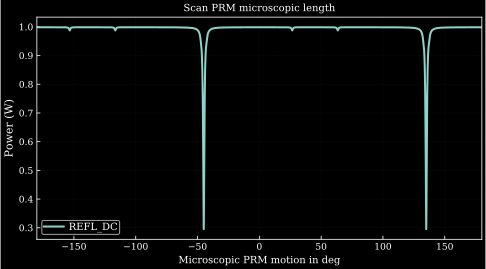

In [4]:
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0
kat_obj.ITMy.phi = -45.0
simulation_code = '''
pd REFL_DC nPRM_1
#pd1 REFL9 9M 0 nPRM_1
#pd1 REFL18 18M nPRM_1
#pd1 REFL18_I 18M 0 nPRM_1
#pd1 REFL18_Q 18M 90 nPRM_1
#pd1 REFL45 45M nPRM_1
#pd1 REFL90 90M nPRM_1

var scan 0.0
set scanre scan re
xaxis scan re lin -180 180 10000

noplot scPRM
func scPRM = (1) * (1) * $scanre
put PRM phi $scPRM
 
yaxis abs

'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(xlabel = 'Microscopic PRM motion in deg',
             ylabel = 'Power (W)',
             title = "Scan PRM microscopic length")

In [5]:
pykat.external.peakdetect.peakdetect(out_obj['REFL_DC'], out_obj.x)

[[[-168.12, 0.998677100014572],
  [-135.0, 0.998705648970735],
  [-101.88, 0.998677100009548],
  [11.88, 0.998677100000922],
  [45.0, 0.998705648984388],
  [78.12, 0.998677099995899]],
 [[-153.432, 0.987576827937807],
  [-116.568, 0.987576829227108],
  [-45.0, 0.29497598482308],
  [26.568, 0.987576834234081],
  [63.432, 0.987576835523827],
  [135.0, 0.294976018493605]]]

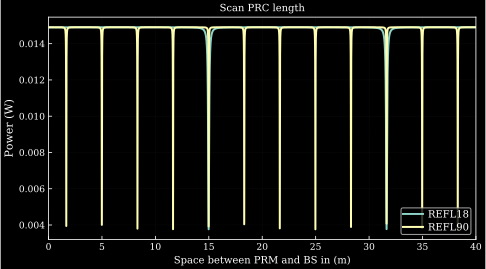

In [7]:
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0
kat_obj.ITMy.phi = -45.0
kat_obj.PRM.phi = 45

simulation_code = '''
#pd REFL_DC nPRM_1
#pd1 REFL9 9M nPRM_1
pd1 REFL18 18M nPRM_1
#pd1 REFL18_I 18M 0 nPRM_1
#pd1 REFL18_Q 18M 90 nPRM_1
#pd1 REFL45 45M nPRM_1
pd1 REFL90 90M nPRM_1

var scan 0.0
set scanre scan re
xaxis scan re lin 0 40 10000

noplot scsPRM_BS
func scsPRM_BS = (1) * (1) * $scanre
put sPRM_BS L $scsPRM_BS
yaxis abs

'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(xlabel = 'Space between PRM and BS in (m)',
             ylabel = 'Power (W)',
             title = "Scan PRC length")

In [9]:
pykat.external.peakdetect.peakdetect(out_obj['REFL18'], out_obj.x)

[[[6.656, 0.0149060696486106], [23.312, 0.0149060696485194]],
 [[14.984, 0.0037643621852275], [31.636, 0.0037709583602216]]]

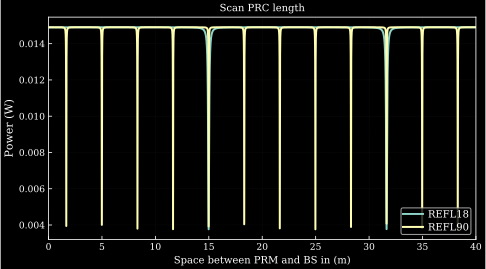

In [8]:
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0
kat_obj.ITMy.phi = -45.0
kat_obj.PRM.phi = 45
kat_obj.sPRM_BS.L = 14.984

simulation_code = '''
#pd REFL_DC nPRM_1
#pd1 REFL9 9M nPRM_1
pd1 REFL18 18M nPRM_1
#pd1 REFL18_I 18M 0 nPRM_1
#pd1 REFL18_Q 18M 90 nPRM_1
#pd1 REFL45 45M nPRM_1
pd1 REFL90 90M nPRM_1

var scan 0.0
set scanre scan re
xaxis scan re lin 0 40 10000

noplot scsPRM_BS
func scsPRM_BS = (1) * (1) * $scanre
put sPRM_BS L $scsPRM_BS
 
yaxis abs
'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(xlabel = 'Space between PRM and BS in (m)',
             ylabel = 'Power (W)',
             title  = "Scan PRC length")

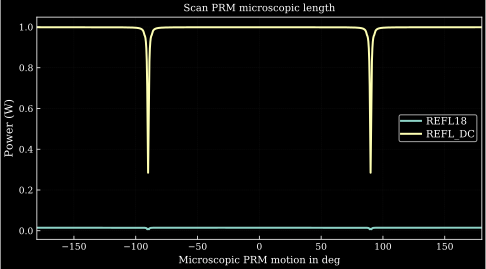

In [54]:
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0
kat_obj.ITMy.phi = -45.0
kat_obj.PRM.phi = 45
kat_obj.sPRM_BS.L = 6.6
simulation_code = '''
pd REFL_DC nPRM_1
#pd1 REFL9 9M 0 nPRM_1
pd1 REFL18 18M nPRM_1
#pd1 REFL18_I 18M 0 nPRM_1
#pd1 REFL18_Q 18M 90 nPRM_1
#pd1 REFL45 45M nPRM_1
#pd1 REFL90 90M nPRM_1

var scan 0.0
set scanre scan re
xaxis scan re lin -180 180 1000

noplot scPRM
func scPRM = (1) * (1) * $scanre
put* PRM phi $scPRM
 
yaxis abs

'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(xlabel = 'Microscopic PRM motion in deg',
             ylabel = 'Power (W)',
             title = "Scan PRM microscopic length")

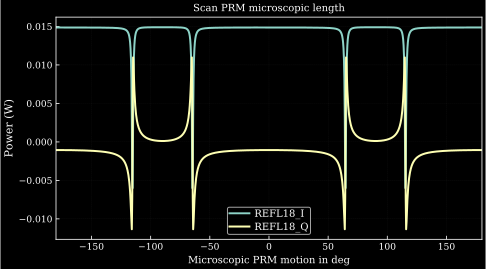

In [37]:
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0
kat_obj.ITMy.phi = -45.0
kat_obj.PRM.phi = 45
kat_obj.sPRM_BS.L = 9.0
simulation_code = '''
#pd REFL_DC nPRM_1
#pd1 REFL9 9M 0 nPRM_1
#pd1 REFL18 18M nPRM_1
pd1 REFL18_I 18M 0 nPRM_1
pd1 REFL18_Q 18M 90 nPRM_1
#pd1 REFL45 45M nPRM_1
#pd1 REFL90 90M nPRM_1

var scan 0.0
set scanre scan re
xaxis scan re lin -180 180 1000

noplot scPRM
func scPRM = (1) * (1) * $scanre
put* PRM phi $scPRM
 
yaxis abs

'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
demod_phase = -18.375
kat_obj.REFL18_I.phase1 = demod_phase
kat_obj.REFL18_Q.phase1 = demod_phase + 90.0

out_obj = kat_obj.run()
out_obj.plot(detectors = ['REFL18_Q', 'REFL18_I'],
             xlabel = 'Microscopic PRM motion in deg',
             ylabel = 'Power (W)',
             title = "Scan PRM microscopic length")

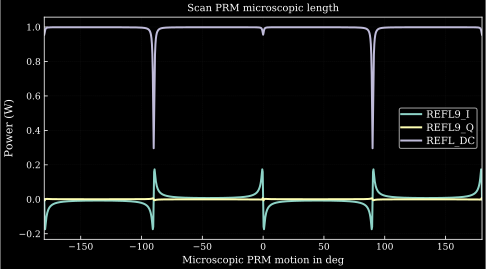

In [35]:
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0
kat_obj.ITMy.phi = -45.0
kat_obj.PRM.phi = 45
kat_obj.sPRM_BS.L = 14.98
simulation_code = '''
pd REFL_DC nPRM_1
#pd1 REFL9 9M nPRM_1
pd1 REFL9_I 9M 0 nPRM_1
pd1 REFL9_Q 9M 90 nPRM_1
#pd1 REFL18 18M nPRM_1
#pd1 REFL18_I 18M 0 nPRM_1
#pd1 REFL18_Q 18M 90 nPRM_1
#pd1 REFL45 45M nPRM_1
#pd1 REFL90 90M nPRM_1

var scan 0.0
set scanre scan re
xaxis scan re lin -180 180 1000

noplot scPRM
func scPRM = (1) * (1) * $scanre
put* PRM phi $scPRM
 
yaxis abs

'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
demod_phase = -9
kat_obj.REFL9_I.phase1 = demod_phase
kat_obj.REFL9_Q.phase1 = demod_phase + 90.0

out_obj = kat_obj.run()
out_obj.plot(#detectors = ['REFL18_Q', 'REFL18_I'],
             xlabel = 'Microscopic PRM motion in deg',
             ylabel = 'Power (W)',
             title = "Scan PRM microscopic length")

In [22]:
demod_phase, og = pykat.ifo.opt_demod_phase(cdata= out_obj['REFL9'],
                                            x = out_obj.x,
                                           xbounds= np.array([-18,18]))
print( demod_phase)

/home/sivananda/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1816: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/home/sivananda/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1817: RuntimeWarning: invalid value encountered in double_scalars
  q = 2.0 * (q - r)
/home/sivananda/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1815: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)


-90.00157928466797


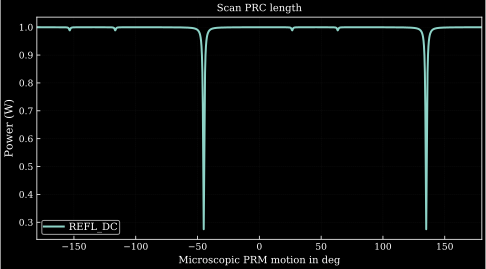

In [40]:
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0
kat_obj.ITMy.phi = -45.0
simulation_code = '''
pd REFL_DC nPRM_1
#pd1 REFL9 9M 0 nPRM_1  [135.0, 0.275059457432883]]]
#pd1 REFL18 18M nPRM_1
#pd1 REFL18_I 18M 0 nPRM_1
#pd1 REFL18_Q 18M 90 nPRM_1
#pd1 REFL45 45M nPRM_1
#pd1 REFL90 90M nPRM_1

var scan 0.0
set scanre scan re
xaxis scan re lin -180 180 1000

noplot scPRM
func scPRM = (1) * (1) * $scanre
put PRM phi $scPRM
 
yaxis abs

'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(xlabel = 'Microscopic PRM motion in deg',
             ylabel = 'Power (W)',
             title = "Scan PRC length")

In [41]:
pykat.external.peakdetect.peakdetect(out_obj['REFL_DC'], out_obj.x)

[[[45.0, 0.999772384195376]], [[-45.0, 0.275059457433059]]]

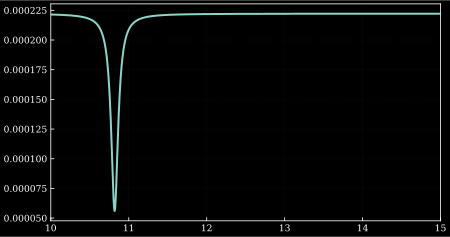

In [122]:
plt.plot(out_obj.x,out_obj['REFL18_I']**2 + out_obj['REFL18_Q']**2)